MLP implementation of ngram language model of context 3.

In [1]:
import torch
import torch.nn.functional as F
#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [208]:
words = open('../names.txt','r').read().splitlines()

In [209]:
chars = ['.']+[chr(ch) for ch in range(ord('a'),ord('z')+1)]
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [299]:
def build_datasets(words):
    X,Y=[],[]
    context_len = 4

    for word in words: #exp
        context = [0]*context_len
        for w  in list(word)+['.']:
            X.append(context)
            Y.append(stoi[w])
            context= context[1:]+[stoi[w]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(407)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr,Ytr = build_datasets(words[:n1])
Xdev,Ydev = build_datasets(words[n1:n2])
Xte,Yte = build_datasets(words[n2:])


In [300]:
print(f' Training set: {Xtr.shape,Ytr.shape}')
print(f' Dev set: {Xdev.shape,Ydev.shape}')
print(f' Test set: {Xte.shape,Yte.shape}')

 Training set: (torch.Size([182502, 4]), torch.Size([182502]))
 Dev set: (torch.Size([22854, 4]), torch.Size([22854]))
 Test set: (torch.Size([22790, 4]), torch.Size([22790]))


Parameters

In [409]:
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27
context_len,emb_space =4,13
hidden_layer_size = 300
C = torch.randn((vocab_size,emb_space),generator=g)
W1 = torch.randn((context_len*emb_space,hidden_layer_size),generator=g)
b1 = torch.randn(hidden_layer_size,generator=g)
W2 = torch.randn((hidden_layer_size,vocab_size),generator=g)
b2 = torch.randn(vocab_size,generator=g)
parameters = [C,W1,W2,b1,b2]

for p in parameters:
    p.requires_grad=True

Training

In [402]:
#track sets
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [316]:
emb.shape

torch.Size([800, 4, 4])

In [410]:
step_size = 10**(-0.60)
batch_size = (W1.shape[0]*50,)
track_loss = []
lri = []
for i in range(10000):
    #mini batch construct
    ix = torch.randint(0,Xtr.shape[0],batch_size) # (90,)

    #forward
    emb = C[Xtr[ix]] # (90,3,3)
    h = torch.tanh(emb.view(-1,W1.shape[0])@W1+b1) #(90,200)
    logits = h@W2 + b2 # (90,27)
    loss = F.cross_entropy(logits,Ytr[ix])

    if loss.item()<2.20:
        if devValidation()-loss.item()>0.04:
            continue
        else:
            break

    #backward
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    # step_size = lrs[i] #using the default lr of 10**(-1.8)
    if loss.item()<2.25:
        step_size = 10**(-1.8)
    for p in parameters:
        p.data+= -p.grad*step_size
    
    # track sets
    # track_loss.append(loss.item())
    # lri.append(lre[i])
    
print(loss.item())

2.205310583114624


(array([-3.  , -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  ,
        -0.75, -0.5 , -0.25,  0.  ]),
 [Text(-3.0, 0, '−3.00'),
  Text(-2.75, 0, '−2.75'),
  Text(-2.5, 0, '−2.50'),
  Text(-2.25, 0, '−2.25'),
  Text(-2.0, 0, '−2.00'),
  Text(-1.75, 0, '−1.75'),
  Text(-1.5, 0, '−1.50'),
  Text(-1.25, 0, '−1.25'),
  Text(-1.0, 0, '−1.00'),
  Text(-0.75, 0, '−0.75'),
  Text(-0.5, 0, '−0.50'),
  Text(-0.25, 0, '−0.25'),
  Text(0.0, 0, '0.00')])

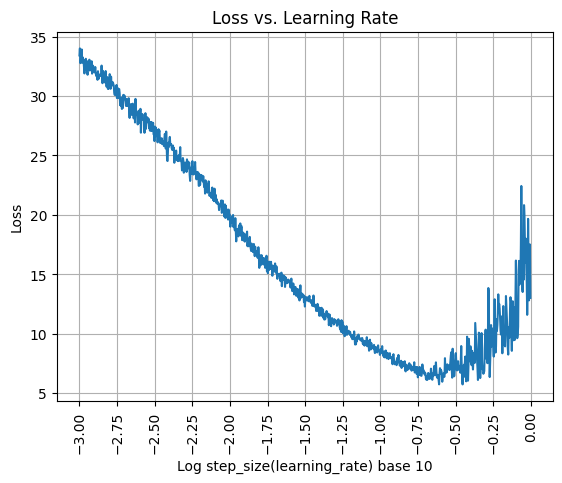

In [404]:
plt.plot(lri[:len(lri)-1],track_loss[1:])
plt.grid(True)
plt.xticks(np.arange(-3, 0 + 0.25, 0.25))
plt.xlabel('Log step_size(learning_rate) base 10') 
plt.ylabel('Loss') 
plt.title('Loss vs. Learning Rate')
plt.xticks(rotation=90)


Conclusion: learning rate of 10**(-0.60) appears to be giving a slow change of loss.

Evaluation using the dev set.

In [411]:
def devValidation():
    emb = C[Xdev] # (:,3,2)
    h = torch.tanh(emb.view(-1,W1.shape[0])@W1+b1) #(:,200)
    logits = h@W2 + b2 # (:,27)
    loss = F.cross_entropy(logits,Ydev) 
    return loss
devValidation()

tensor(2.2734, grad_fn=<NllLossBackward0>)

In [414]:
def testValidation():
    emb = C[Xte] # (:,3,2)
    h = torch.tanh(emb.view(-1,W1.shape[0])@W1+b1) #(:,200)
    logits = h@W2 + b2 # (:,27)
    loss = F.cross_entropy(logits,Yte) 
    return loss
testValidation()

tensor(2.2611, grad_fn=<NllLossBackward0>)

Saving the model parameters

In [412]:
# torch.save(parameters,'../Model_backup/mlp_parameters.pth') #Storing the data in Model_backup folder

Loading the parameters

In [ ]:
# parameters = torch.load('../Model_backup/mlp_parameters.pth')

Visualising the 2d embedding vector

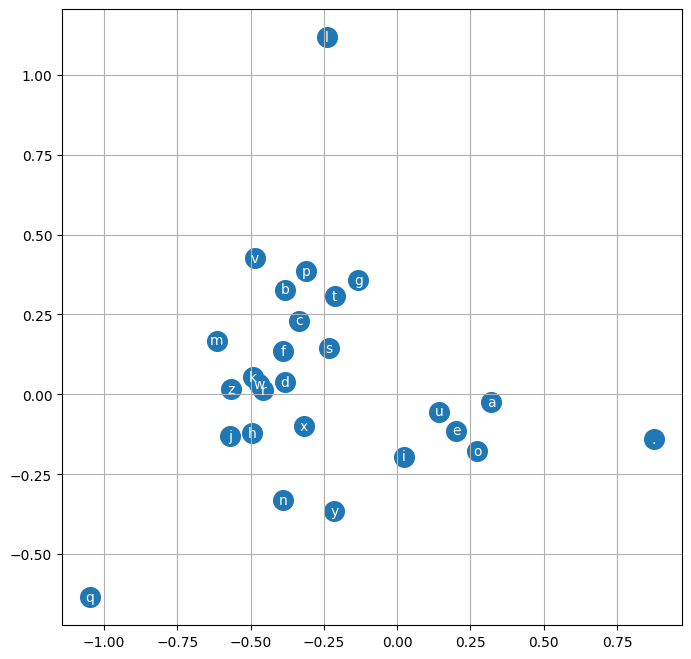

In [186]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)# C is a 2d embedding table with 27 rows and 2 cols.
for i in range(C.shape[0]):
    plt.text(C[i,0].data,C[i,1].data, itos[i], ha="center", va="center",color="white")
plt.grid('minor')